In [30]:
#In this exercise we are pricing an European Call Option using Black-Scholes model and Monte Carlo simulations.
#European options can only be exercised at maturity.

In [31]:
#Import required libraries
import numpy as np
import pandas as pd
import pandas_datareader as pdr
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [32]:
#Write Black-Scholes model formula
def bsm_call(S_t, K, r, sigma, T):
    den = 1 / (sigma * np.sqrt(T))
    d1 = den * (np.log(S_t / K) + (r + 0.5 * sigma ** 2) * T)
    d2 = den * (np.log(S_t / K) + (r - 0.5 * sigma ** 2) * T)
    C = S_t * stats.norm.cdf(d1) \
        - K * np.exp(-r * T) * stats.norm.cdf(d2)
    return C

In [33]:
#Retrieve financial data
start_date = '2015-01-01'
end_date = '2016-01-04'
fb_data = pdr.DataReader("FB", "yahoo", start_date, end_date)
fb_data.tail()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2015-12-28,105.980003,104.529999,105.019997,105.930000,13069700,105.930000
2015-12-29,107.739998,106.250000,106.419998,107.260002,17179900,107.260002
2015-12-30,107.250000,106.059998,107.000000,106.220001,13115000,106.220001
2015-12-31,106.169998,104.620003,106.000000,104.660004,18391100,104.660004
2016-01-04,102.239998,99.750000,101.949997,102.220001,37912400,102.220001


In [34]:
#Calculated anual volatility using the data previously acquired 
ret = fb_data['Close'][1:].values / fb_data['Close'][:-1].values - 1
sigma = np.std(ret) * np.sqrt(252)
print(sigma)

0.25740530517111704


In [35]:
# Get the risk-free rate
rfr = pdr.DataReader("DGS10", "fred", end_date)
rfr.head()

,DGS10
DATE,
2016-01-04,2.24
2016-01-05,2.25
2016-01-06,2.18
2016-01-07,2.16
2016-01-08,2.13


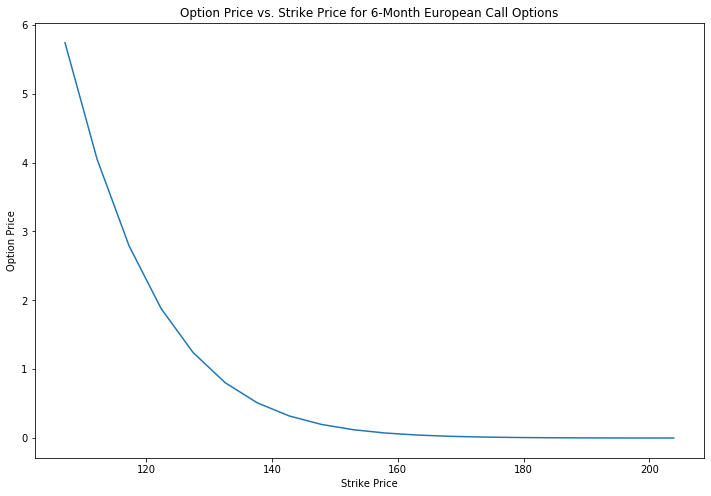

In [36]:
# Get the opening price on the day of interest
S_t = fb_data['Open'][-1]
# Range of strike prices
K = S_t *(1 + np.linspace(0.05, 1, 20))
# Risk free rate on day of interest
r = rfr.loc[fb_data.index[-1]][0]
# Time to maturity in year fractions
T = 0.5

# Calculate option prices
C = [bsm_call(S_t, k, r / 100, sigma, T) for k in K]

plt.figure(figsize=(12,8))
plt.plot(K, C)
plt.xlabel("Strike Price")
plt.ylabel("Option Price")
plt.title("Option Price vs. Strike Price for 6-Month European Call Options")
plt.show()

#By plotting different strike prices, we can show how as it increases, the value of the option decreases.
#This makes sense since the higher the strike price, the lower the probability of exercising the call option

In [37]:
#Monte Carlo Simulations

# Keep values from previous BSM for comparison
K_bsm = K[0]
C_bsm = C[0]

In [38]:
np.random.seed(20)

# Parameters same values as used in the example above 
# Initial asset price
S_0 = S_t
# Strike price for call option
K = K_bsm
# Time to maturity in years
T = 0.5
# Risk-free rate of interest
r = rfr.loc[fb_data.index[-1]][0] / 100
# Historical Volatility
sigma = np.std(ret) * np.sqrt(252)
# Number of time steps for simulation
n_steps = int(T * 252)
# Time interval
dt = T / n_steps
# Number of simulations
N = 100000
# Zero array to store values (often faster than appending)
S = np.zeros((n_steps, N))
S[0] = S_0

In [39]:
for t in range(1, n_steps):
    # Draw random values to simulate Brownian motion
    Z = np.random.standard_normal(N)
    S[t] = S[t - 1] * np.exp((r - 0.5 * sigma ** 2) * \
                             dt + (sigma * np.sqrt(dt) * Z))

# Sum and discount values
C = np.exp(-r * T) * 1 / N * np.sum(np.maximum(S[-1] - K, 0))
C

print("Strike price: {:.2f}".format(K_bsm))
print("BSM Option Value Estimate: {:.2f}".format(C_bsm))
print("Monte Carlo Option Value Estimate: {:.2f}".format(C))

#We can actually see how the value of the option using BSM and Monte Carlo simulations is very close

Strike price: 107.05
BSM Option Value Estimate: 5.74
Monte Carlo Option Value Estimate: 5.70


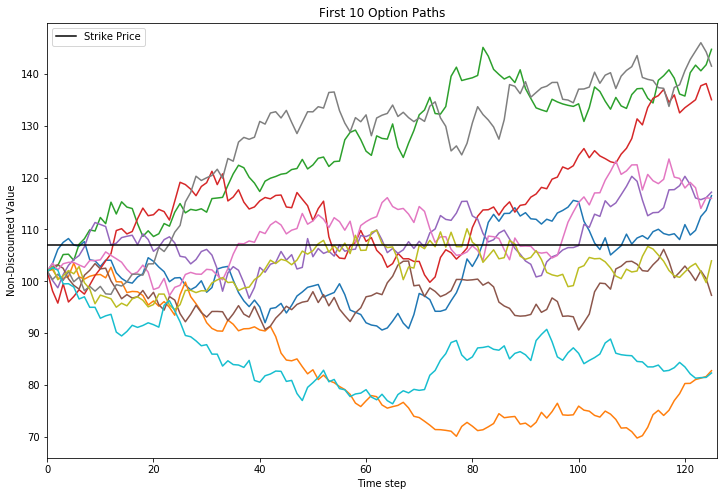

In [40]:
#Visualize Monte Carlo simulations
plt.figure(figsize=(12,8))
plt.plot(S[:,0:10])
plt.axhline(K, c="k", xmin=0,
            xmax=n_steps,
           label="Strike Price")
plt.xlim([0, n_steps])
plt.ylabel("Non-Discounted Value")
plt.xlabel("Time step")
plt.title("First 10 Option Paths")
plt.legend(loc="best")
plt.show()
